In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
import sys 
import pickle
from rdkit import Chem
from rdkit.Chem import AllChem
from imblearn.under_sampling import RandomUnderSampler
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
from VisUtils import *

In [63]:
def oversample(file_path,filename, sampling):
    """Oversample the datasetes using the SMOTE or ADASYN
    Keeps the feature names and id cols
    file_name (full/absolute path): use the scaled dataframe we just created above 'NEK#_binding_moe_scaled_df.csv'
    sampling (str): 'SMOTE' or 'ADASYN'
    returns: oversampled dataframe
    """

    df = pd.read_csv(file_path+filename)
    original_cols = df.columns.to_list() 
    
    feature_names = original_cols[0:-5]
    other_cols = original_cols[-5:]
    id_col_names = other_cols[0:4]
    id_cols = df[id_col_names]
    
    id_cols = ['compound_id', 'base_rdkit_smiles', 'fold'] 
    active_col = ['active'] 
    exclude_cols = id_cols +active_col
    feature_names = [col for col in df.columns if col not in ['compound_id', 'base_rdkit_smiles', 'fold','subset'] ]
    # feature_names = df_original.columns.difference(exclude_cols)
    
    train_df = df[df['subset'] == 'train']
    test_df = df[df['subset'] == 'test']
    trainX = train_df[feature_names]
    testX = test_df[feature_names]
    if 'subset' in trainX.columns:
        print("'subset'col here")
        trainX = trainX.drop(columns=['subset'])
        display(trainX)
    elif 'subset.1' in trainX.columns:
        print("'subset.1' col here")
        trainX = trainX.drop(columns=['subset.1'])
    if 'subset' in testX.columns:
        print("'subset'col here")
        testX = testX.drop(columns=['subset'])
    elif 'subset.1' in testX.columns:
        print("'subset.1' col here")
        testX = testX.drop(columns=['subset.1'])
    trainy = train_df['active']
    testy = test_df['active']
    test_ids = test_df[id_col_names]
    print(f'original train size: {train_df.shape}, original test size: {test_df.shape}')
 
    if sampling == 'ADASYN':
        oversample = ADASYN(random_state=42)
    else: 
        oversample = SMOTE(random_state=42)
        
    trainX_temp, trainy_temp = oversample.fit_resample(trainX.to_numpy(), trainy.to_numpy().reshape(-1))
    print(f'train after {sampling}: {trainX_temp.shape}')
    print(f"Shape of trainX_temp: {trainX_temp.shape}")
    # print(f"Number of feature names: {len(feature_names)}")
    trainX_resamp = pd.DataFrame(trainX_temp, columns=feature_names)
    trainy_resamp = pd.DataFrame(trainy_temp, columns=['active'])
    placeholder='synthetic '+sampling
    syn_samples=pd.DataFrame({col:[placeholder]*len(trainX_resamp) for col in id_col_names})

    train_resamp= pd.concat([syn_samples,trainX_resamp,trainy_resamp], axis=1)
    train_resamp['subset'] = 'train'
    
    
    test_df_final = pd.concat([test_ids.reset_index(drop=True),testX.reset_index(drop=True),testy.reset_index(drop=True)],axis=1)
    # test_df_final = pd.concat([testX.reset_index(drop=True),testy.reset_index(drop=True)],axis=1)
    test_df_final['subset'] = 'test'

    final_df = pd.concat([train_resamp,test_df_final]).reset_index(drop=True)
    return final_df 
        

In [64]:
def smiles_to_fps(smiles_list, radius=2, nBits=2048):
    fps = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
            arr = np.zeros((1,), dtype=np.int8)
            Chem.DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
    return np.array(fps)

def make_smiles(file_path, filename):
    """Create Morgan Fingerpint features from smiles srrings 
    file_path: directory of datafame
    filename: any dataframe with active, base_rdkit_smiles, fold, compound_id
    returns: final dataframe with morgan fingerprints based on the original dataframe's smiles strings 
    """
    df = pd.read_csv(file_path+filename)
    train_y = df[df['subset']=='train']['active']
    test_y=df[df['subset']=='test']['active']
    train_sm = df[df['subset']=='train']['base_rdkit_smiles']
    test_sm = df[df['subset']=='test']['base_rdkit_smiles']
    train_id = df[df['subset']=='train']['compound_id']
    test_id = df[df['subset']=='test']['compound_id']
    train_fold = df[df['subset']=='train']['fold']
    test_fold = df[df['subset']=='test']['fold']
    
    trainX_mfp = smiles_to_fps(train_sm, radius=2)
    testX_mfp = smiles_to_fps(test_sm, radius=2)
    
    trainX_mfp_df = pd.DataFrame(trainX_mfp)
    testX_mfp_df = pd.DataFrame(testX_mfp)

    trainX_mfp_df['subset'] = 'train'
    testX_mfp_df['subset'] = 'test'
    
    trainX_mfp_df['base_rdkit_smiles'] = train_sm.reset_index(drop=True)
    testX_mfp_df['base_rdkit_smiles'] = test_sm.reset_index(drop=True)
    trainX_mfp_df['compound_id'] = train_id.reset_index(drop=True)
    testX_mfp_df['compound_id'] = test_id.reset_index(drop=True)
    trainX_mfp_df['fold'] = train_fold.reset_index(drop=True)
    testX_mfp_df['fold'] = test_fold.reset_index(drop=True)
    
    trainX_mfp_df['active'] = train_y.reset_index(drop=True)
    testX_mfp_df['active'] = test_y.reset_index(drop=True)
    final_df = pd.concat([trainX_mfp_df,testX_mfp_df], ignore_index=True)
    return final_df
        

In [65]:
data_dir = '/Users/jayceepang/msse/capstone/data/NEK_ATOM_data/'
this_dir = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
neks = ['2','3','5','9']
folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        nek_path= f'{data_dir}NEK{nek}/'
        assay_file = f'NEK{nek}_1_uM_min_50_pct_{bi}_5fold_random_imbalanced.csv'
        print(nek, bi)
        for fold in folds: 
            fold_dir = f'{this_dir}{fold}/'
            final_csv_name = f'NEK{nek}_{bi}_moe_scaled_df_{fold}.csv'
            final_mfp_csv_name= f'NEK{nek}_{bi}_mfp_scaled_df_{fold}.csv'
            # final_df.to_csv(f'{fold_dir}{final_csv_name}', index=False)
            # mfp_df = make_smiles(fold_dir, final_csv_name)
            # mfp_df.to_csv(f'{fold_dir}{final_mfp_csv_name}', index=False)
            
            smote_df = oversample(fold_dir, final_csv_name, 'SMOTE')
            smote_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_moe_SMOTE_df_{fold}.csv',index=False)
            smote_df_mfp = oversample(fold_dir, final_csv_name, 'SMOTE') 
            smote_df_mfp.to_csv(f'{fold_dir}NEK{nek}_{bi}_mfp_SMOTE_df_{fold}.csv',index=False)
            
            adasyn_df = oversample(fold_dir, final_csv_name, 'ADASYN')
            adasyn_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_moe_ADASYN_df_{fold}.csv',index=False)
            adasyn_df_mfp = oversample(fold_dir, final_csv_name, 'ADASYN') 
            adasyn_df_mfp.to_csv(f'{fold_dir}NEK{nek}_{bi}_mfp_ADASYN_df_{fold}.csv',index=False)
            
            # smote_mfp_df = make_smiles(fold_dir, f'NEK{nek}_{bi}_moe_SMOTE_df_{fold}.csv')
            # smote_mfp_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_mfp_SMOTE_df_{fold}.csv',index=False)
            
            
            # adasyn_mfp_df = make_smiles(fold_dir, f'NEK{nek}_{bi}_moe_ADASYN_df_{fold}.csv')
            # adasyn_mfp_df.to_csv(f'{fold_dir}NEK{nek}_{bi}_mfp_ADASYN_df_{fold}.csv',index=False)

2 binding
original train size: (1125, 311), original test size: (283, 311)
train after SMOTE: (2160, 307)
Shape of trainX_temp: (2160, 307)
original train size: (1125, 311), original test size: (283, 311)
train after SMOTE: (2160, 307)
Shape of trainX_temp: (2160, 307)
original train size: (1125, 311), original test size: (283, 311)
train after ADASYN: (2163, 307)
Shape of trainX_temp: (2163, 307)
original train size: (1125, 311), original test size: (283, 311)
train after ADASYN: (2163, 307)
Shape of trainX_temp: (2163, 307)
original train size: (1126, 311), original test size: (282, 311)
train after SMOTE: (2162, 307)
Shape of trainX_temp: (2162, 307)
original train size: (1126, 311), original test size: (282, 311)
train after SMOTE: (2162, 307)
Shape of trainX_temp: (2162, 307)
original train size: (1126, 311), original test size: (282, 311)
train after ADASYN: (2170, 307)
Shape of trainX_temp: (2170, 307)
original train size: (1126, 311), original test size: (282, 311)
train after 

In [71]:
def add_cm2(df): 
    true_labels = df['y'] 
    predictions = df['prediction']
    cm = confusion_matrix(true_labels, predictions )
    cm_flattened = cm.flatten().tolist()
    df['cm'] = [cm_flattened]* len(df)
    df['prediction_type'] = df.apply(lambda x: prediction_type(x['y'], x['prediction']), axis=1) 
    df['f1'] = f1_score(df['y'], df['prediction'])
    df['ROC-AUC'] = roc_auc_score(df['y'], df['prediction'])
    df['MCC'] = matthews_corrcoef(df['y'], df['prediction'])
    df['Balanced Accuracy'] = balanced_accuracy_score(df['y'], df['prediction'])
    return df

In [77]:
drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
save_path ='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        
        RF_type = 'RF'
        for feat in ['moe', 'mfp']: 
            for samp in ['SMOTE', 'ADASYN']: 
                for fold in folds: 
                    print(f'NEK{nek} {bi} {feat}')
                    fold_dir = f'{this_dir}{fold}/'
                    df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_{samp}_df_{fold}.csv')
                    
                    trainX = df[df['subset'] == 'train'] 
                    train_y = trainX['active'].to_numpy() 
                    drop_cols=['subset', 'compound_id', 'base_rdkit_smiles',
                                     'fold', 'active', 'subset.1', 'active','active.1']
                    if 'subset.1' in trainX.columns: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles',
                                     'fold', 'active', 'subset.1', 'active','active.1']
                    else: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles',
                                     'fold', 'active', 'active', 'active.1'] 
                    trainX = trainX.drop(columns=drop_cols).to_numpy()
                    
                    testX = df[df['subset'] == 'test'] 
              
                    test_y = testX['active'].to_numpy()
                    if 'subset.1' in testX.columns: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles',
                                     'fold', 'active', 'subset.1', 'active','active.1'] 
                    else: 
                        drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles',
                                     'fold', 'active', 'active','active.1']
                    testX = testX.drop(columns=drop_cols).to_numpy()
                    model = rf_models(trainX, train_y, testX, test_y, RF_type, {})
                    train_df = gather_rf_results(model, trainX, train_y)
                    test_df = gather_rf_results(model, testX, test_y)
                    train_df['subset'] = 'train' 
                    test_df['subset'] = 'test' 
                    model_name = f'NEK{nek}_{bi}_{feat}_{samp}_RF_{fold}' 
                    train_df['model'] = model_name
                    test_df['model'] = model_name
                    train_df = add_cm2(train_df)
                    test_df = add_cm2(test_df)
                    
                    train_df['NEK'] = f'NEK{nek}_{bi}'
                    train_df['feat_type'] = feat
                    train_df['strategy'] = samp
                    train_df['RF_type'] = RF_type
                    test_df['NEK'] = f'NEK{nek}_{bi}'
                    test_df['feat_type'] = feat
                    test_df['strategy'] = samp
                    test_df['RF_type'] = RF_type
                    test_df['train_fold'] = fold
                    train_df['train_fold'] = fold
                    
                    with open(f'{fold_dir}{model_name}.pkl', 'wb') as f: 
                        pickle.dump(model,f)
            
                    train_df.to_csv(f'{fold_dir}{model_name}_train_results.csv',index=False) 
                    test_df.to_csv(f'{fold_dir}{model_name}_test_results.csv',index=False) 
                    

NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.943, precision: 0.300, recall: 0.250, specificity: 0.974
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.915, precision: 0.227, recall: 0.417, specificity: 0.937
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.932, precision: 0.278, recall: 0.455, specificity: 0.952
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.907, precision: 0.200, recall: 0.455, specificity: 0.926
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.929, precision: 0.200, recall: 0.273, specificity: 0.956
NEK2 binding moe
TRAIN: accuracy: 1.000, precision: 1.000, recall: 1.000, specificity: 1.000
TEST: accuracy: 0.936, precision: 0.200, recall: 0.167, specificity

In [106]:
data_dir = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/undersampler_validation/idea5_dir/'
drop_cols = ['subset', 'compound_id', 'base_rdkit_smiles', 'fold', 'active'] 
results = [] 
metric_cols = ['accuracy', 'precision', 'recall', 'specificity','TN', 'FN', 'FP', 'TP','f1', 'ROC-AUC', 'MCC', 'Balanced Accuracy',
       'model', 'cm', 'prediction_type', 'NEK', 'feat_type', 'strategy','RF_type','train_fold']
# metric_cols = [ 'NEK','strategy','RF_type','feat_type','set', 'cm','recall','specificity','accuracy', 'precision','TN', 'FN', 'FP', 'TP',
#        'model', 'f1', 'ROC-AUC', 'MCC', 'Balanced Accuracy','prediction_type']
for i, nek in enumerate(neks):
    if nek in ['2','9']: 
        bind_inhib = ['binding', 'inhibition']
    else: 
        bind_inhib = ['binding'] 
    for bi in bind_inhib: 
        if bi == 'binding': 
            this_bi = 'bind'
        else: 
            this_bi = 'inhib' 
        for feat in ['moe', 'mfp']:
            for samp in ['SMOTE', 'ADASYN']: 
                for fold in folds: 
                    fold_dir = f'{this_dir}{fold}/'
                    result_df = pd.read_csv(f'{fold_dir}NEK{nek}_{bi}_{feat}_{samp}_RF_{fold}_test_results.csv')
                    results.append(result_df.iloc[[0]][metric_cols].values.flatten())
                    
                        
results_df =  pd.DataFrame(results,columns=metric_cols)
results_df['model'] = results_df['model'].str.replace('scaled', 'raw')
results_df['strategy'] =results_df['strategy'].str.replace('scaled', 'raw')
results_df['strategy'] = results_df['strategy'].str.replace('scaled', 'raw')
results_df['modeling_type'] = 'RF'  
results_df['RF_type'] = 'RF' 
results_df['modeling_type'] = 'RF' 
# results_df['subset'] = results_df['train_fold'] 
# results_df['set'] = results_df['subset'] 
# results_df['set'] = 'foldvalidation'
results_df['set'] = results_df['train_fold'] 
other_rf = pd.read_csv(data_dir+'RF_results_all_folds.csv')
other_rf
all_rf_folds = pd.concat([other_rf, results_df])
all_rf_folds.to_csv(data_dir+'RF_results_all_folds.csv', index=False) 

In [107]:
all_rf_folds

,accuracy,precision,recall,specificity,TN,FN,FP,TP,f1,ROC-AUC,...,model,cm,prediction_type,NEK,feat_type,strategy,RF_type,train_fold,modeling_type,set
0,0.558304,0.068702,0.750000,0.549815,149,3,122,9,0.125874,0.649908,...,NEK2_binding_moe_UNDER_RF_fold1,"[149, 122, 3, 9]",TN,NEK2_binding,moe,UNDER,RF,fold1,RF,foldvalidation
1,0.759717,0.088235,0.500000,0.771218,209,6,62,6,0.150000,0.635609,...,NEK2_binding_moe_raw_BRFC_fold1,"[209, 62, 6, 6]",TN,NEK2_binding,moe,raw,BRFC,fold1,RF,foldvalidation
2,0.692580,0.087912,0.666667,0.693727,188,4,83,8,0.155340,0.680197,...,NEK2_binding_moe_raw_BRFC_BCW_fold1,"[188, 83, 4, 8]",TN,NEK2_binding,moe,raw,BRFC_BCW,fold1,RF,foldvalidation
3,0.581560,0.072581,0.750000,0.574074,155,3,115,9,0.132353,0.662037,...,NEK2_binding_moe_UNDER_RF_fold2,"[155, 115, 3, 9]",TN,NEK2_binding,moe,UNDER,RF,fold2,RF,foldvalidation
4,0.719858,0.096386,0.666667,0.722222,195,4,75,8,0.168421,0.694444,...,NEK2_binding_moe_raw_BRFC_fold2,"[195, 75, 4, 8]",FP,NEK2_binding,moe,raw,BRFC,fold2,RF,foldvalidation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.887500,0.500000,0.555556,0.929577,66,4,5,5,0.526316,0.742567,...,NEK9_inhibition_mfp_ADASYN_RF_fold1,"[66, 5, 4, 5]",TN,NEK9_inhibition,mfp,ADASYN,RF,fold1,RF,fold1
116,0.886076,0.500000,0.666667,0.914286,64,3,6,6,0.571429,0.790476,...,NEK9_inhibition_mfp_ADASYN_RF_fold2,"[64, 6, 3, 6]",TN,NEK9_inhibition,mfp,ADASYN,RF,fold2,RF,fold2
117,0.910256,0.555556,0.625000,0.942857,66,3,4,5,0.588235,0.783929,...,NEK9_inhibition_mfp_ADASYN_RF_fold3,"[66, 4, 3, 5]",TN,NEK9_inhibition,mfp,ADASYN,RF,fold3,RF,fold3
118,0.961538,0.857143,0.750000,0.985714,69,2,1,6,0.800000,0.867857,...,NEK9_inhibition_mfp_ADASYN_RF_fold4,"[69, 1, 2, 6]",TN,NEK9_inhibition,mfp,ADASYN,RF,fold4,RF,fold4


In [109]:
original_results = pd.read_excel('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/general_NEK/GP_GPmatern_RF_RFGS_results_all_sets.xlsx')
original_results = original_results[(original_results['set']=='original') & (original_results['modeling_type'] == 'RF')]
under_rf= original_results[(original_results['strategy'] == 'UNDER') &(original_results['RF_type'] == 'RF')]
other_us = original_results[(original_results['strategy'] == 'raw') & original_results['RF_type'].isin(['BRFC','BRFC_BCW'])]
all_under = pd.concat([under_rf, other_us])
og_cols = list(all_under.columns)
fold_results = results_df[og_cols] 
fold_results['bal type'] = fold_results['strategy'].astype(str)+'_'+fold_results['RF_type']+'_'+fold_results['set'] 
all_under['bal type'] = all_under['strategy'].astype(str)+'_'+all_under['RF_type']
comparison_us = pd.concat([all_under, fold_results])
comparison_us['modeling_type'] = 'RF' 
comparison_us['1-specificity'] = 1-comparison_us['specificity']
comparison_us.to_excel('fold_comparison_oversampling.xlsx', index=False)
comparison_us['nek type'] = comparison_us['NEK'].astype(str).str.split('_').str[1]

# FOLDs

In [110]:
fold_results['1-specificity'] = 1-fold_results['specificity']
fold_results['nek type'] = fold_results['NEK'].astype(str).str.split('_').str[1]
fold_bind = fold_results[fold_results['nek type'] == 'binding'] 
fold_inhib = fold_results[fold_results['nek type'] == 'inhibition'] 

# fold data (nothing from original data) 

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_91645/2555613071.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


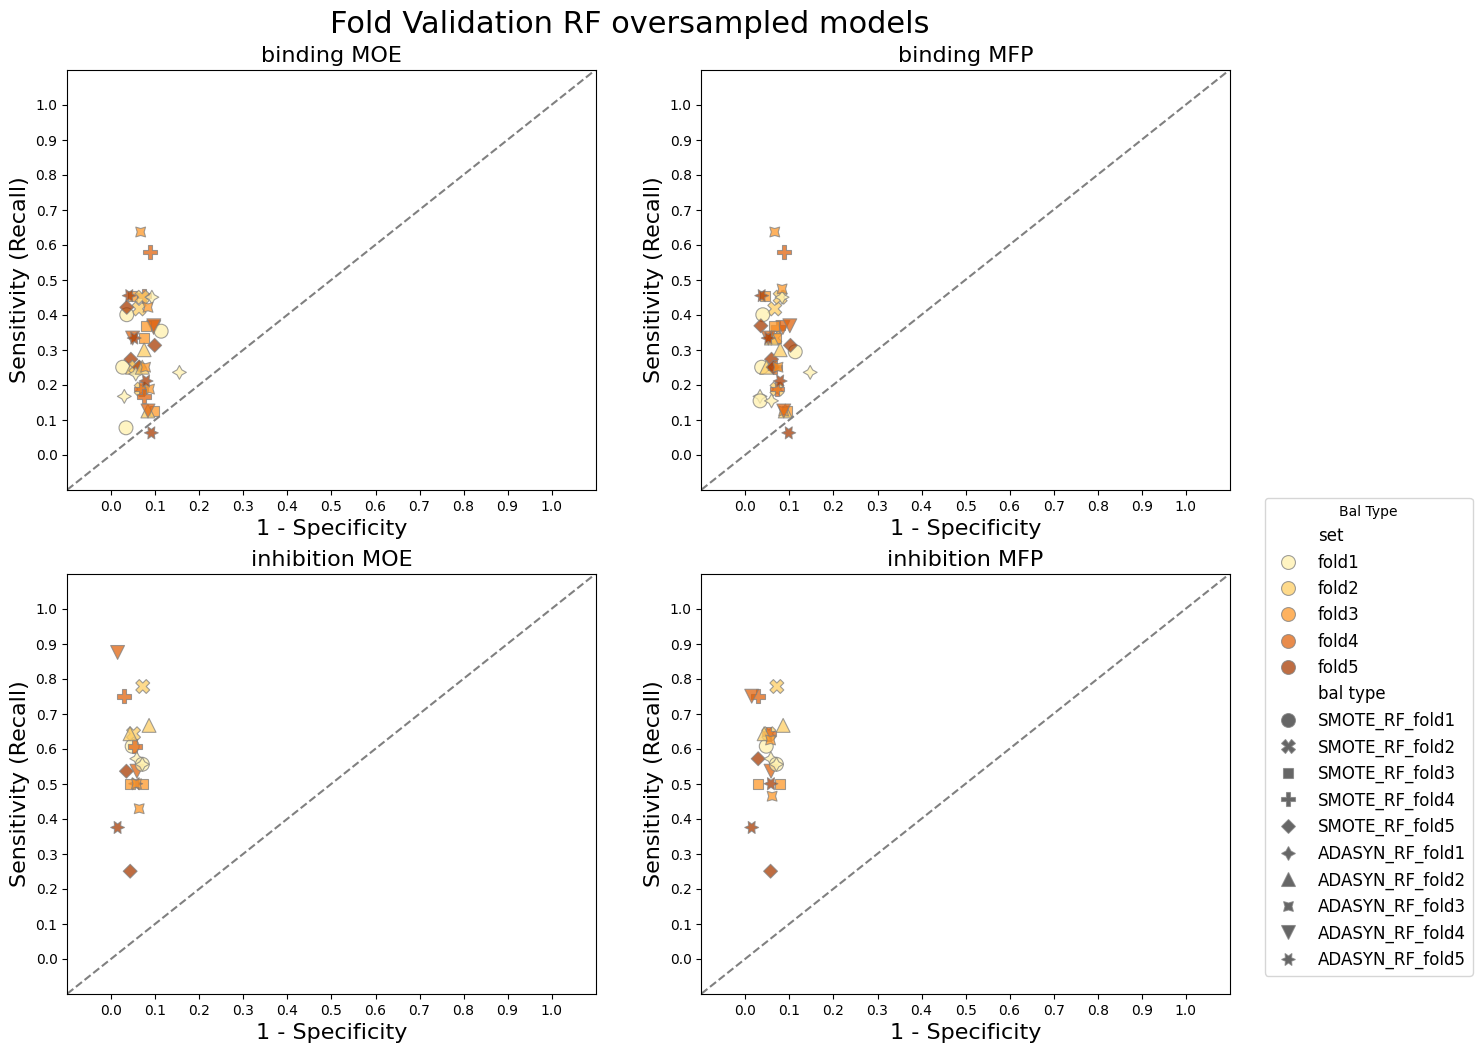

In [112]:
special_palette4 = {'raw_RF': 'cornflowerblue', 'raw_RF_BCW': 'cyan', 
                   'raw_BRFC': 'blue', 'raw_BRFC_BCW': 'black', 
                   'UNDER_RF': 'tab:orange', 'ADASYN_RF': 'tab:red', 
                   'raw_GP':'cornflowerblue', 'UNDER_GP':'tab:orange', 'ADASYN_GP':'tab:red' , 
                   'ADASYN': 'tab:red', 'SMOTE': 'hotpink'}
unique_cats = fold_bind['set'].nunique()
ylobr = sns.color_palette("YlOrBr", n_colors=unique_cats)
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([fold_bind,fold_inhib])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='set',style='bal type',
                   alpha=0.75, palette=ylobr,s=100, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='set',style='bal type',
                   alpha=0.75, palette=ylobr,s=100,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF oversampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_oversampled_RF.png',bbox_inches='tight')

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_91645/1591281332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_os['model version'] = comparison_os['RF_type'].astype(str)+'_'+comparison_us['strategy']
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_91645/1591281332.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.4))


ADASYN_RF_fold1
ADASYN_RF_fold2
ADASYN_RF_fold3
ADASYN_RF_fold4
ADASYN_RF_fold5


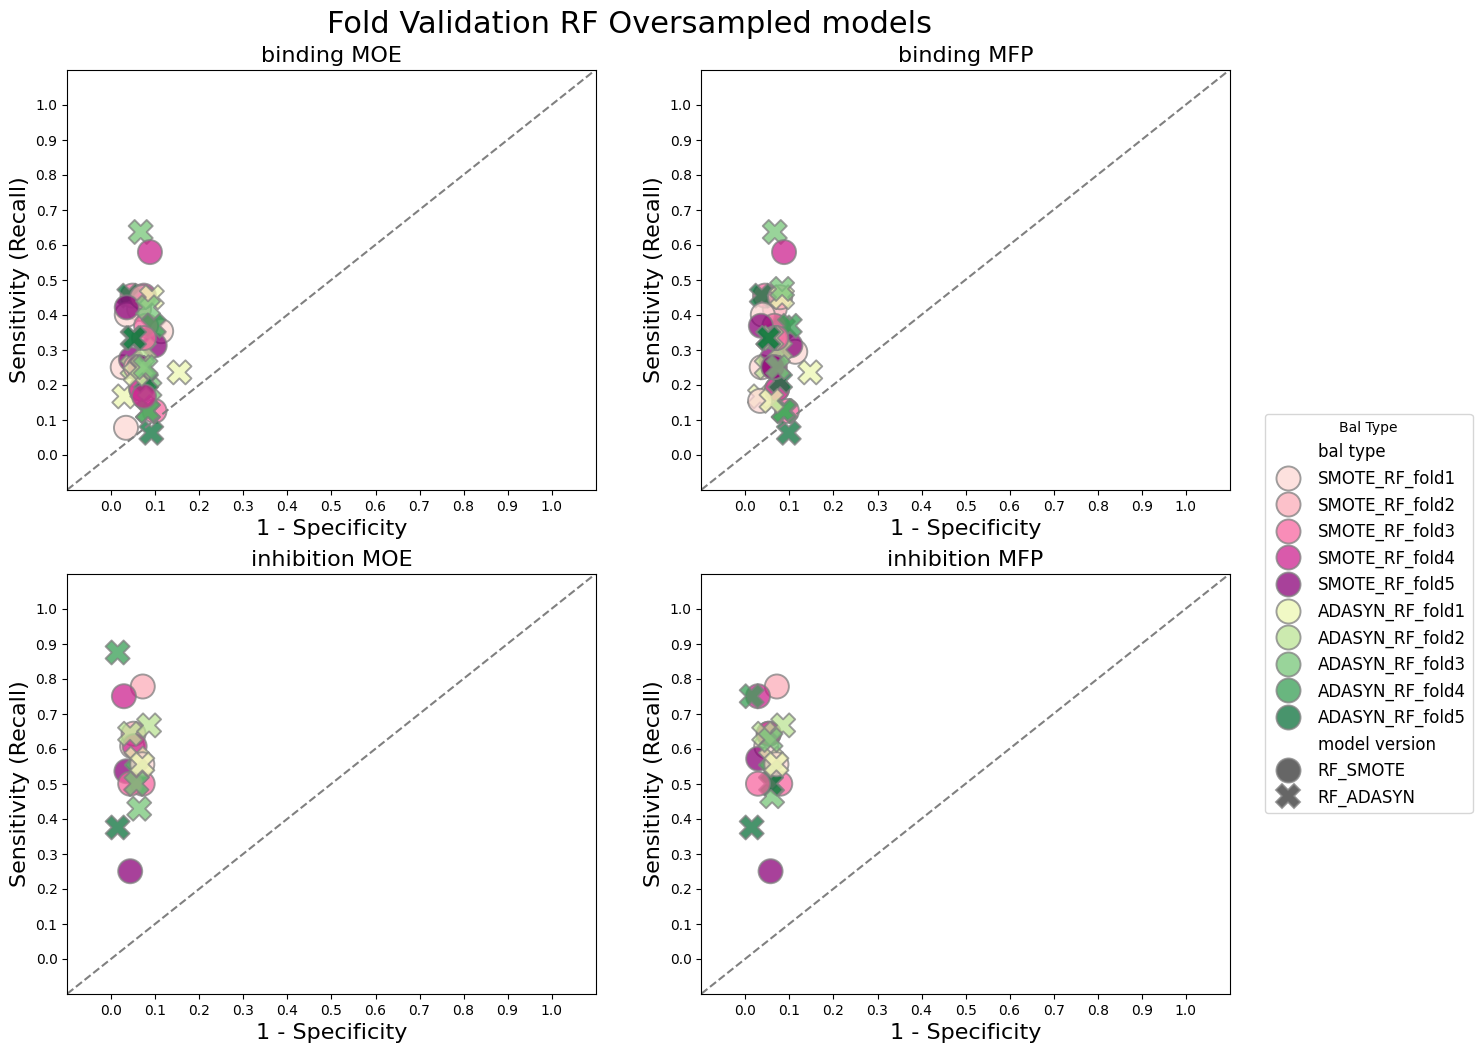

In [134]:
comparison_os = comparison_us[(comparison_us['strategy']=='SMOTE')|(comparison_us['strategy']=='ADASYN')]
comparison_os['model version'] = comparison_os['RF_type'].astype(str)+'_'+comparison_us['strategy'] 
bind2 = comparison_os[comparison_os['nek type'] =='binding']
inhib2 = comparison_os[comparison_os['nek type'] =='inhibition'] 

import matplotlib.colors as mcolors
# yellows = sns.color_palette("YlOrBr", n_colors=5)
yellows = sns.color_palette("RdPu",n_colors=5)
hex_colors_yellows = [mcolors.to_hex(color) for color in yellows]
smote_folds = ['SMOTE_RF_fold1','SMOTE_RF_fold2','SMOTE_RF_fold3','SMOTE_RF_fold4','SMOTE_RF_fold5']
for color,strat in zip(hex_colors_yellows,smote_folds): 
    special_palette5[strat] = color 

ADASYN_folds = ['ADASYN_RF_fold1','ADASYN_RF_fold2','ADASYN_RF_fold3','ADASYN_RF_fold4','ADASYN_RF_fold5']
blues= sns.color_palette("YlGn", n_colors=5)
hex_colors_ADASYN = [mcolors.to_hex(color) for color in blues]
for color,strat in zip(hex_colors_ADASYN,ADASYN_folds): 
    print(strat)
    special_palette5[strat] = color 

# BRFC_BCW_folds = ['raw_BRFC_BCW_fold1','raw_BRFC_BCW_fold2','raw_BRFC_BCW_fold3','raw_BRFC_BCW_fold4','raw_BRFC_BCW_fold5']
# pinks = sns.color_palette("light:salmon", n_colors=5)
# hex_colors_BRFC_BCW = [mcolors.to_hex(color) for color in pinks]
# for color,strat in zip(hex_colors_BRFC_BCW,BRFC_BCW_folds): 
#     print(strat)
#     special_palette5[strat] = color 

fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.4))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF Oversampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_oversampled_all_RFtypes.png',bbox_inches='tight')

# try just RF models 


/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_91645/3866558433.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))


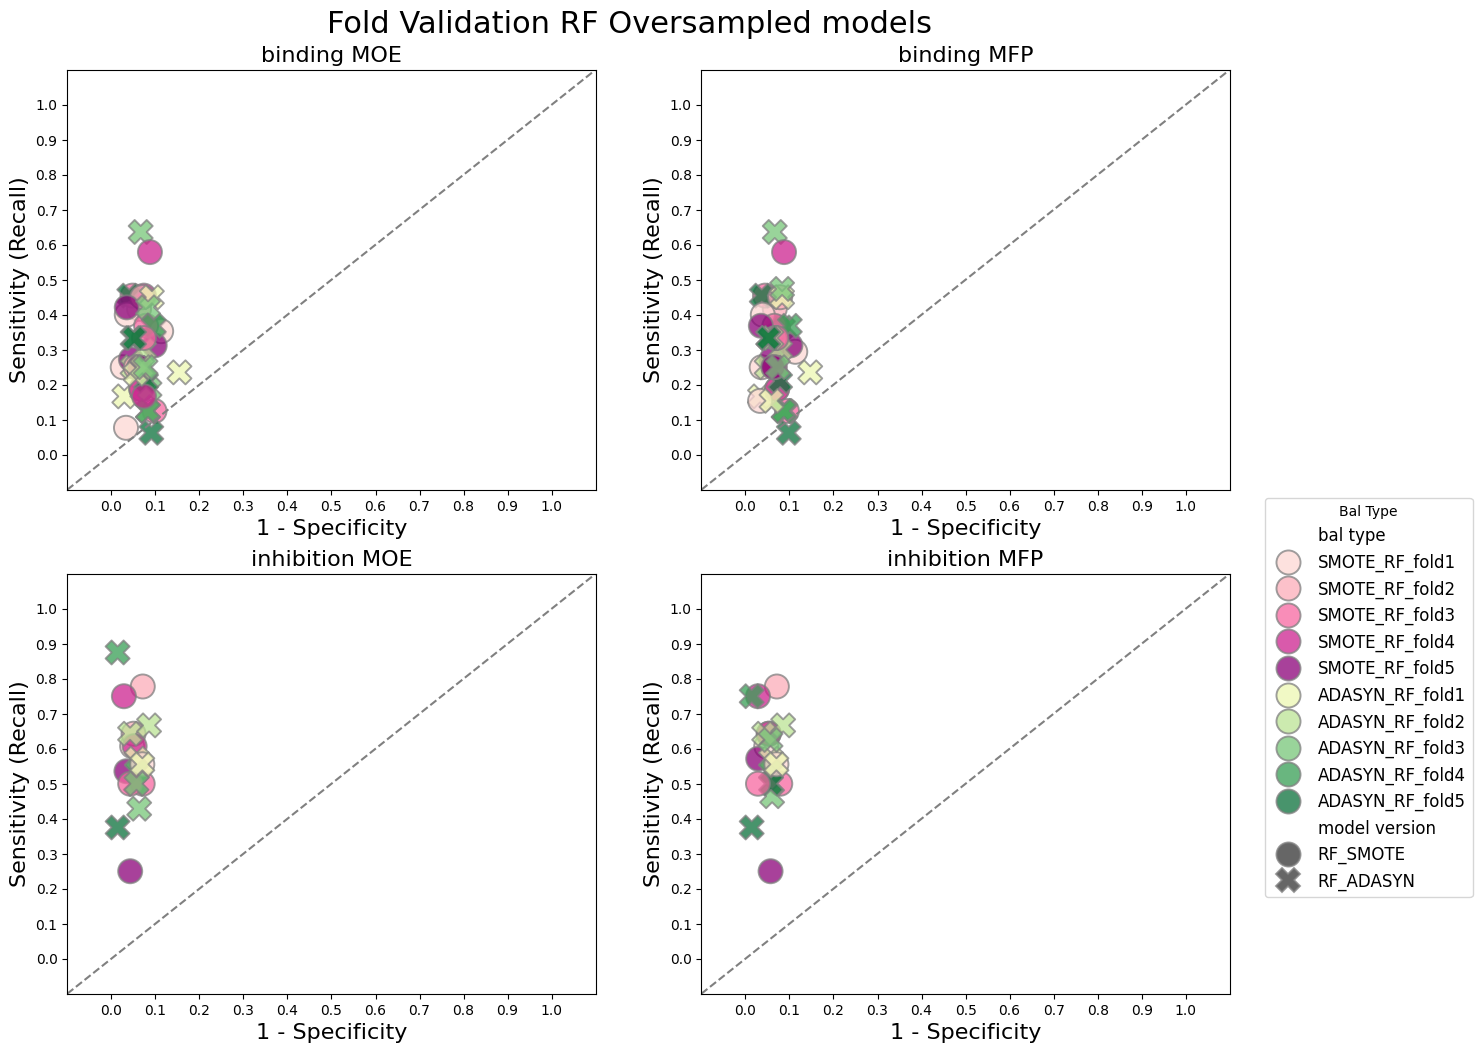

In [135]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind2,inhib2])): 
    this_df = this_df[this_df['RF_type'] =='RF']
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    # print('moe') 
    # print(moe_df['bal type'].value_counts())
    # print('mfp') 
    # print(mfp_df['bal type'].value_counts())
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='bal type', style='model version',
                   alpha=0.75, palette=special_palette5,s=300, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='bal type',style='model version',
                   alpha=0.75, palette=special_palette5,s=300,legend=True, ax=axs[i,1],edgecolor='gray')
    
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    axs[1,1].legend(title='Bal Type', fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axs[i, 0].set_title(f'{moe_df["nek type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["nek type"].iloc[0]} MFP', fontsize=16)
plt.suptitle('Fold Validation RF Oversampled models', fontsize=22, y=.93)
plt.savefig('fold1to5_oversampled_all_RFtypes.png',bbox_inches='tight')